# Setup and EDA

## Imports and Functions

In [1]:
from processing_utils import preprocess
import pygam
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import itertools
import seaborn as sns

## EDA

In [2]:
variables = ['TA_F', 'SW_IN_F', 'P_F', 'WS_F', 'VPD_F', 'CO2_F_MDS', 'SWC_F_MDS_1']
backup_variables = {}
labels = ['GPP_NT_VUT_REF']
data, var = preprocess('CZ-BK1', 'FULLSET', '2004-2008', '2-3', 'DD', variables, backup_variables, labels, [])
data[var + labels].head()

Loading: FLX_CZ-BK1_FLUXNET2015_FULLSET_DD_2004-2008_2-3.csv
Total rows: 1826

1826


,TA_F,SW_IN_F,P_F,WS_F,VPD_F,CO2_F_MDS,avg_fAPAR_interpol,time_index,GPP_NT_VUT_REF
0,-3.377,11.058,8.615,0.816,0.067,390.229,5.85,0,0.0768981
1,-6.252,31.298,1.304,0.894,0.201,391.26,5.66,1,0.0401639
2,-8.74,27.314,1.47,0.995,0.146,385.598,5.47,2,0.239468
3,-11.722,22.078,0.469,0.924,0.075,358.001,5.28,3,0.238272
4,-12.542,38.863,0.597,0.838,0.106,358.456,5.86,4,-0.303437


In [3]:
display(data.head(), data.shape)

,TIMESTAMP,TA_F_MDS,TA_F_MDS_QC,TA_F_MDS_NIGHT,TA_F_MDS_NIGHT_SD,TA_F_MDS_NIGHT_QC,TA_F_MDS_DAY,TA_F_MDS_DAY_SD,TA_F_MDS_DAY_QC,TA_ERA,...,GPP_DT_CUT_25,GPP_DT_CUT_50,GPP_DT_CUT_75,GPP_DT_CUT_84,GPP_DT_CUT_95,RECO_SR,RECO_SR_N,time_index,GPP_NT_VUT_REF_train,avg_fAPAR_interpol
0,20040101,-0.074,0.0,-0.521,0.896,0.0,0.741,0.736,0.0,-3.377,...,1.46159,1.54065,1.59951,1.61276,1.68855,-9999,-9999,0,0.0401639,5.85
1,20040102,0.708,0.0,0.164,0.912,0.0,1.7,1.193,0.0,-6.252,...,3.17474,3.29312,3.38762,3.40742,3.45706,-9999,-9999,1,0.239468,5.66
2,20040103,0.386,0.0,-0.227,0.975,0.0,1.504,0.683,0.0,-8.74,...,2.91846,3.036,3.12728,3.1468,3.19754,-9999,-9999,2,0.238272,5.47
3,20040104,-0.074,0.0,-0.521,0.896,0.0,0.741,0.736,0.0,-11.722,...,2.53189,2.64427,2.73015,2.74882,2.79961,-9999,-9999,3,-0.303437,5.28
4,20040105,0.708,0.0,0.164,0.912,0.0,1.7,1.193,0.0,-12.542,...,3.67187,3.77606,3.89622,3.91691,3.96584,-9999,-9999,4,-0.105307,5.86


(1826, 341)

In [ ]:
print([col for col in data.columns if col[-2:] == '_F'])
print([col for col in data.columns if 'CO2' in col])
print(sorted([col for col in data.columns if col[:2] == 'TA']))
print()

## Variable Selection

X variables: TA, SW, VPD, WS, P, CO2 
Y variables: NEE, GPP, RECO
NEE = net carbon exchange -> use NEE_CUT_REF or NEE_VUT_REF
GPP = total carbon uptake -> use GPP_DT_VUT_REF or GPP_NT_VUT_REF (or CUT)
RECO = respiration -> RECO_DT_VUT_REF

if using DT for one, use DT for another
focus on GPP first for now

remi prefers VUT
need remote sensing information
 
for input->output, want to predict "current day" accurately based on last x days, dont care the models outputs up
until current day. 

instant effects: CO2, WS, VPD
longer-term effects: SW, TA, P

for memory length, try 30 days at most first

DAYTIME is generated from a model, may not want to use that or compare to both daytime and nighttime

if not in the site data, just dont use, but should be pretty rare

normalize the variables before training

Manual variable selection:

In [ ]:
variables = ['TA_F', 'SW_IN_F', 'P_F', 'WS_F', 'VPD_F']
labels = ['GPP_NT_VUT_REF']
data[variables + labels].head()

PCA:

In [ ]:
actual_measurements = [col for col in data.columns if ('QC' not in col) 
                       and ('UNC' not in col) and ('METHOD' not in col)
                      and ('SD' not in col) and ('CORR' not in col) 
                       and ('MEAN' not in col) and ('SE' not in col) and ('TIMESTAMP' not in col)
                      and ('NEE' not in col) and ('RECO' not in col)
                      and ('GPP' not in col)]
def pca(df, list_of_variables, k, normalize_matrix=True, choose_by_size=True):
    measurements = df[list_of_variables].to_numpy()
    mu = measurements.mean(0)
    transformed = measurements - mu
    if normalize_matrix:
        transformed = normalize(transformed, axis=0, norm='l1')
    eigenvalues, eigenvectors = np.linalg.eig(np.matmul(transformed.T, transformed))
    if choose_by_size:
        projection_matrix = []
        for i in range(k):
            max_eig = np.argmax(eigenvalues)
            eigenvalues = np.delete(eigenvalues, max_eig)
            projection_matrix.append(eigenvectors[:, max_eig])
            eigenvectors = np.delete(eigenvectors, max_eig, axis=1)
            
        projection_matrix = np.array(projection_matrix).T
    else:
        projection_matrix = eigenvectors[:, 0:k]
    pca_measurements = np.matmul(measurements, projection_matrix)
    return pca_measurements

# GAM

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00


['TA_F', 'SW_IN_F', 'P_F', 'WS_F', 'VPD_F', 'CO2_F_MDS', 'avg_fAPAR_interpol']


 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     29.7371
Link Function:                     IdentityLink Log Likelihood:                                 -3576.0311
Number of Samples:                         1826 AIC:                                             7213.5363
                                                AICc:                                            7214.6237
                                                GCV:                                                2.3474
                                                Scale:                                              2.2787
                                                Pseudo R-Squared:                                   0.8563
Feature Function                  Lam

/home/jszou/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  import sys


'Pseudo r2 explained deviance:0.8562758670036266'

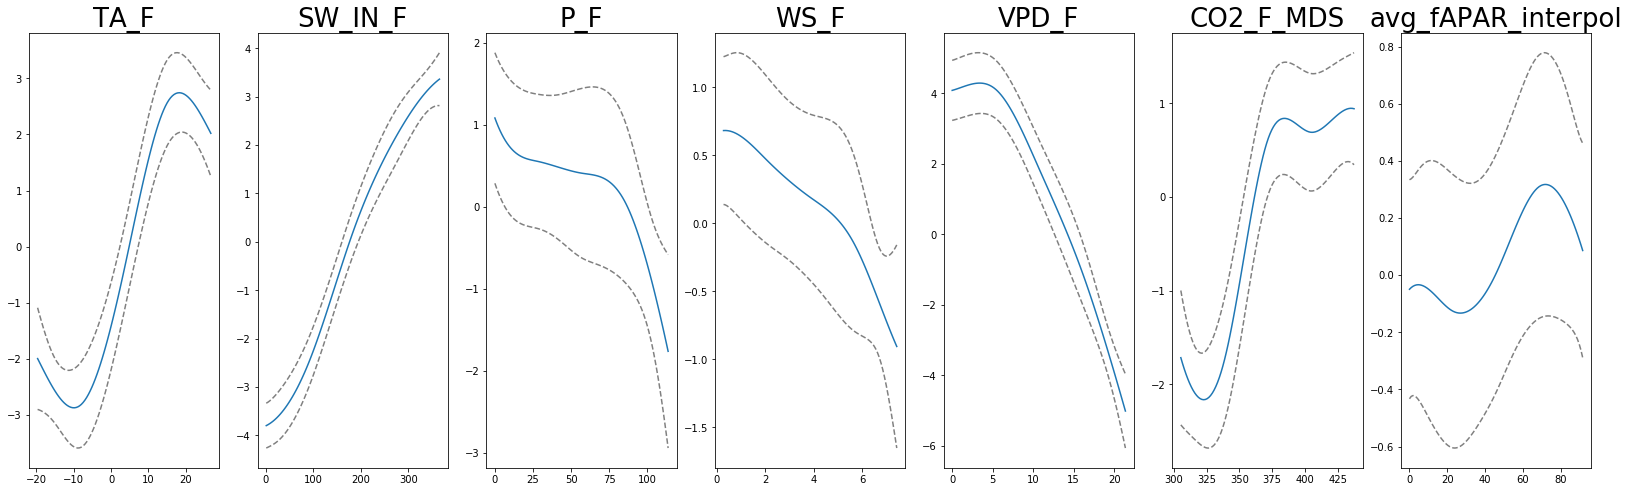

In [4]:
gam_var = var.copy()
gam_var.remove("time_index")
print(gam_var)
y = data[labels].to_numpy(dtype='float')
X = data[gam_var].to_numpy(dtype='float')
gam = pygam.GAM(n_splines=len(variables)).gridsearch(X, y)
gam.summary()
display("Pseudo r2 explained deviance:" + str(gam.statistics_['pseudo_r2']['explained_deviance']))
plt.rcParams['figure.figsize'] = (28,8)
fig, axs = plt.subplots(1, len(gam_var))
titles = gam_var
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(i, X=XX, width=.95)
    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi[:, 0], c='grey', ls='--')
    ax.plot(XX[:, i], confi[:, 1], c='grey', ls='--')
    ax.set_title(titles[i],fontsize=26)
# plt.show()
plt.savefig('viz/GAM_dump/GAM.png')
# variable_subsets = []
# for i in range(4, len(variables)+1):
#     for c in itertools.combinations(variables, i):
#         variable_subsets += [list(c)]
# variable_subsets

# max_pseudo_r2 = float('-inf')
# best_subset = None
# for ss in variable_subsets:
#     X = data[ss].to_numpy(dtype='float')
#     gam = pygam.GAM(n_splines=len(ss)).gridsearch(X, y)
#     if gam.statistics_['pseudo_r2']['explained_deviance'] > max_pseudo_r2:
#         max_pseudo_r2 = gam.statistics_['pseudo_r2']['explained_deviance']
#         best_subset = ss
# print(best_subset, max_pseudo_r2)

# LSTM

## Set up training data

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import Sampler

class TimeseriesSampler(Sampler):
    """Samples sequences from the dataset using the given window size and step size
        data_source (Dataset): dataset to sample from
    """
    def __init__(self, data_source, window_size=5, step_size=1, shuffle=False):
        self.data_source = data_source
        self.windows = []
        for i in range(0, len(data_source)-window_size+1, step_size):
            self.windows.append(list(range(i, i+window_size)))
        if shuffle:
            random.shuffle(self.windows)
        
    def __iter__(self):
        return iter(self.windows)

    def __len__(self):
        return len(self.data_source)

sequence_length = 10
split_frac = 0.9
k = 5

print(variables)
num_key_variables = len(variables)
# processed = pd.DataFrame(pca(data, variables, num_key_variables))
processed = data[variables + labels].iloc[0:100].astype('float32')
# processed[labels] = data[labels]
# processed = processed.iloc[0:100]

train_indexes, val_indexes, test_split_index = split_dataset(processed, split_frac, k)
test = processed.iloc[test_split_index-sequence_length:]

train = processed.iloc[train_indexes[-1]]
val = processed.iloc[val_indexes[-1]]
train_data = TensorDataset(torch.from_numpy(train[variables].to_numpy()), 
                           torch.from_numpy(train[labels].to_numpy()))
val_data = TensorDataset(torch.from_numpy(val[variables].to_numpy()),
                         torch.from_numpy(val[labels].to_numpy()))
test_data = TensorDataset(torch.from_numpy(test[variables].to_numpy()), 
                          torch.from_numpy(test[labels].to_numpy()))

batch_size = 1
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size,
                         sampler=TimeseriesSampler(train_data, sequence_length+1, shuffle=True))
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size,
                       sampler=TimeseriesSampler(val_data, sequence_length+1))
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size,
                        sampler=TimeseriesSampler(test_data, sequence_length+1))

In [ ]:
# for i, l in train_loader:
#     print(i)
#     print(l)
#     print(l.squeeze()[-1])
target_variables = ['TA_F', 'SW_IN_F', 'P_F', 'WS_F', 'VPD_F', 'CO2_F']
backup_variables = {'TA_F' : 'TA_F_MDS', 'SW_IN_F': 'SW_IN_F_MDS', 'P_F': 'P_F_MDS', 'CO2_F': 'CO2_F_MDS', 'WS_F': 'WS_F_MDS', 'VPD_F': 'VPD_F_MDS'}
variables = []
for v in target_variables:
    if v in data.columns:
        variables.append(v)
    elif backup_variables[v] in data.columns:
        variables.append(backup_variables[v])
variables

## Set-up model

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        super(SimpleLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.input_size = input_size
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        out = out.view(batch_size, -1)
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [ ]:
output_size = 1
hidden_dim = 512
n_layers = 3

model = SimpleLSTM(num_key_variables, output_size, hidden_dim, n_layers)
model.to(device)

model.zero_grad()
inputs = torch.zeros([batch_size, sequence_length, num_key_variables], dtype=torch.float32)
lbls = torch.zeros([batch_size, 1], dtype=torch.float32)
h = model.init_hidden(batch_size)
h = ([e.data for e in h])
output, h = model(inputs, h)
output.squeeze()[-1].item()

# Training

In [ ]:
output_size = 1
hidden_dim = 512
n_layers = 3

model = SimpleLSTM(num_key_variables, output_size, hidden_dim, n_layers)
model.to(device)

lr=0.0005
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

epochs = 10
counter = 0
print_every = int(len(train_loader)/2)
clip = 5
valid_loss_min = np.Inf

model.train()
for i in range(epochs):
    h = model.init_hidden(batch_size)
    
    for inputs, lbls in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, lbls = inputs.to(device), lbls.squeeze().to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        # we only care about the last output for now
        loss = criterion(output.squeeze()[-1], lbls.float()[-1])
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if counter%print_every == 0:
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.squeeze().to(device)
                out, val_h = model(inp, val_h)
                val_loss = criterion(out.squeeze()[-1], lab.float()[-1])
                val_losses.append(val_loss.item())
                
            model.train()
            mean_val_loss = np.mean(val_losses)
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(mean_val_loss))

            if mean_val_loss <= valid_loss_min:
                torch.save(model.state_dict(), './state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,mean_val_loss))
                valid_loss_min = mean_val_loss

## Testing

In [ ]:
test_losses = []
test_predictions = []
h = model.init_hidden(batch_size)

model.eval()
for inputs, truth in test_loader:
    h = tuple([each.data for each in h])
    inputs, truth = inputs.to(device), truth.to(device)
    output, h = model(inputs, h)
    pred = output.squeeze()[-1]
    test_loss = criterion(pred, truth.float()[-1])
    test_losses.append(test_loss.item())
    test_predictions.append(pred.item())

print("Test loss: {:.3f}".format(np.mean(test_losses)))

training_predictions = []
h = model.init_hidden(batch_size)

all_train = processed.iloc[np.append(train_indexes[-1], val_indexes[-1])]
all_train_data = TensorDataset(torch.from_numpy(all_train[variables].to_numpy()), 
                           torch.from_numpy(all_train[labels].to_numpy()))
all_training_data_loader = DataLoader(all_train_data, shuffle=False, batch_size=batch_size,
                                     sampler=TimeseriesSampler(all_train_data, sequence_length+1, shuffle=False))

model.eval()
for x, y in all_training_data_loader:
    h = tuple([each.data for each in h])
    x, y = x.to(device), y.to(device)
    output, h = model(x, h)
    pred = output.squeeze()[-1]
    training_predictions.append(pred.item())

offset = sequence_length + 1
train_len = len(training_predictions)
test_len = len(test_predictions)
x = range(sequence_length + train_len + test_len)

plt.figure()
plt.title('Predictions vs. Ground Truth')
plt.xlabel('Days since 2003-01-01')
sns.lineplot(x=x, y=processed[labels[0]], label='ground truth')
sns.lineplot(x=x, y=(([np.nan] * sequence_length) + training_predictions + ([np.nan] * test_len)), 
             label='train predictions')
sns.lineplot(x=x, y=([np.nan] * (train_len + sequence_length) ) + test_predictions, 
             label='test predictions', color='red')
plt.show();